In [ ]:
import ast
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('cleaned_restaurants.csv')
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,RestaurantsDelivery
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",0
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",1
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",1
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",0
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",1


In [ ]:
df.shape

(31372, 15)

In [ ]:
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].astype(int)

In [ ]:
#Compare group means
df.groupby('RestaurantsDelivery')['stars'].mean()

# 3. Do t-test
from scipy.stats import ttest_ind

delivery = df[df['RestaurantsDelivery'] == 1]['stars']
no_delivery = df[df['RestaurantsDelivery'] == 0]['stars']

t_stat, p_val = ttest_ind(delivery, no_delivery, equal_var=False)
print("T-statistic:", t_stat)
print("P-value:", p_val)


T-statistic: -44.53655338922241
P-value: 0.0


In [ ]:
X = df[['RestaurantsDelivery']]            # predictor
X = sm.add_constant(X)                     # add intercept
y = df['stars']                            # outcome

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1687.
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:37:37   Log-Likelihood:                -38860.
No. Observations:               31372   AIC:                         7.772e+04
Df Residuals:                   31370   BIC:                         7.774e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.8094    

In [ ]:
import pandas as pd
import ast
import numpy as np

# -----------------------------
# 1. Parse the attributes column
# -----------------------------
def parse_attributes(raw):
    if pd.isna(raw):
        return {}
    if isinstance(raw, dict):
        return raw
    try:
        return ast.literal_eval(raw)
    except:
        return {}

df['attr_dict'] = df['attributes'].apply(parse_attributes)


# -----------------------------
# 2. Cleaning helpers
# -----------------------------
def normalize_str(x):
    if x is None or pd.isna(x):
        return None
    if not isinstance(x, str):
        return x
    x = x.strip()
    if len(x) >= 2 and (x[0] == x[-1]) and x[0] in "'\"":
        x = x[1:-1]
    if x.lower() in ["none", "null", "nan", ""]:
        return None
    return x

def to_bool01(x):
    x = normalize_str(x)
    if x is None:
        return np.nan
    xl = str(x).lower()
    if xl in ["true", "yes", "1"]:
        return 1
    if xl in ["false", "no", "0"]:
        return 0
    return np.nan

def to_numeric(x):
    x = normalize_str(x)
    try:
        return float(x)
    except:
        return np.nan


# -----------------------------
# 3. Extract ONLY regression attributes
# -----------------------------
regression_bool_attrs = [
    'RestaurantsReservations',
    'OutdoorSeating',
    'GoodForKids',
    'BusinessAcceptsCreditCards',
    'RestaurantsTakeOut'
]

regression_numeric_attrs = [
    'RestaurantsPriceRange2'
]

# Boolean predictors → turn into 0/1
for a in regression_bool_attrs:
    df[a] = df['attr_dict'].apply(lambda d: to_bool01(d.get(a)))

# Numeric predictor
for a in regression_numeric_attrs:
    df[a] = df['attr_dict'].apply(lambda d: to_numeric(d.get(a)))


# -----------------------------
# 4. Export only relevant columns (optional)
# -----------------------------
export_cols = [
    'business_id', 'name', 'stars', 'review_count', 'RestaurantsDelivery',
    'RestaurantsPriceRange2', 'RestaurantsReservations', 'OutdoorSeating',
    'GoodForKids', 'BusinessAcceptsCreditCards', 'RestaurantsTakeOut'
]

final_df = df[export_cols]

#final_df.to_csv("restaurants_regression_attributes.csv", index=False)


In [ ]:
corr_vars = [
    'stars',
    'RestaurantsDelivery',
    'review_count',
    'RestaurantsPriceRange2',
    'RestaurantsReservations',
    'OutdoorSeating',
    'GoodForKids',
    'BusinessAcceptsCreditCards',
    'RestaurantsTakeOut'
]

df_corr = df[corr_vars].astype(float)


In [ ]:
corr_matrix = df_corr.corr()
corr_matrix

,stars,RestaurantsDelivery,review_count,RestaurantsPriceRange2,RestaurantsReservations,OutdoorSeating,GoodForKids,BusinessAcceptsCreditCards,RestaurantsTakeOut
stars,1.000000,-0.225900,0.174427,0.281666,0.209818,0.199863,-0.051611,-0.079319,0.093122
RestaurantsDelivery,-0.225900,1.000000,-0.019332,-0.150899,-0.080319,-0.070470,0.174869,0.108803,0.127440
review_count,0.174427,-0.019332,1.000000,0.275295,0.166300,0.191894,-0.066981,-0.003029,0.014607
RestaurantsPriceRange2,0.281666,-0.150899,0.275295,1.000000,0.485891,0.178851,-0.242584,0.063918,-0.043834
RestaurantsReservations,0.209818,-0.080319,0.166300,0.485891,1.000000,0.130958,-0.166374,0.052798,-0.026251
OutdoorSeating,0.199863,-0.070470,0.191894,0.178851,0.130958,1.000000,-0.118615,0.039249,0.019988
GoodForKids,-0.051611,0.174869,-0.066981,-0.242584,-0.166374,-0.118615,1.000000,0.016616,0.162160
BusinessAcceptsCreditCards,-0.079319,0.108803,-0.003029,0.063918,0.052798,0.039249,0.016616,1.000000,0.007820
RestaurantsTakeOut,0.093122,0.127440,0.014607,-0.043834,-0.026251,0.019988,0.162160,0.007820,1.000000


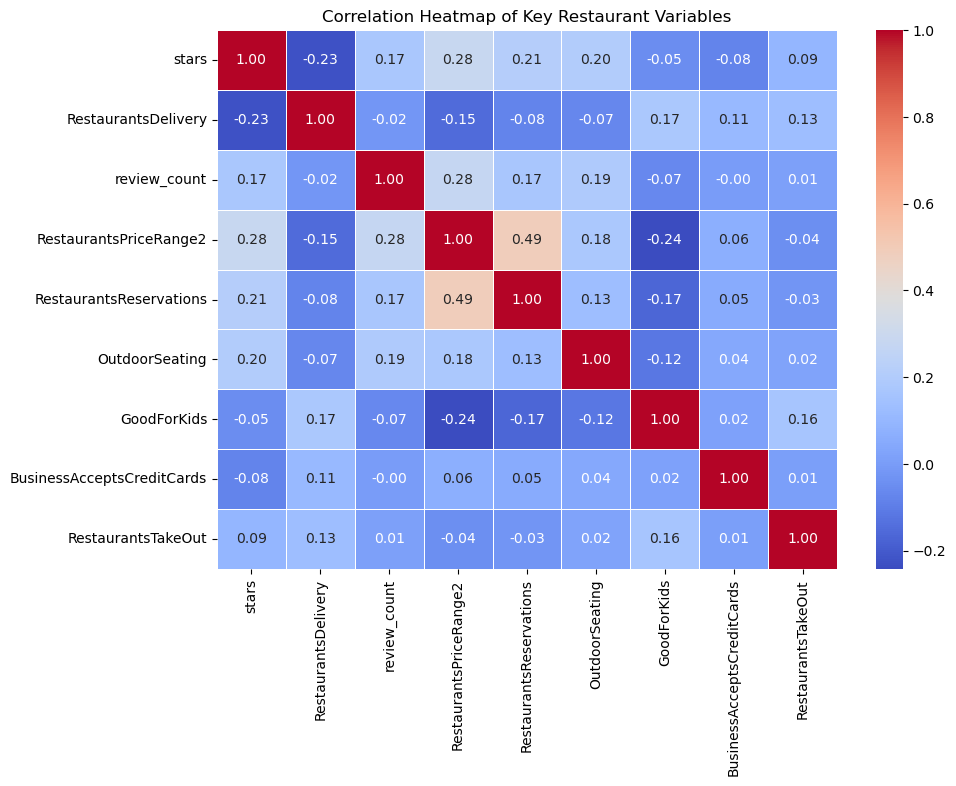

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title("Correlation Heatmap of Key Restaurant Variables")
plt.show()


In [ ]:
# --- Parse attribute string into dictionary ---
def parse_attributes(raw):
    if pd.isna(raw):
        return {}
    if isinstance(raw, dict):
        return raw
    try:
        return ast.literal_eval(raw)
    except:
        return {}

df['attr_dict'] = df['attributes'].apply(parse_attributes)


# --- Utility functions ---
def normalize_str(x):
    if x is None or pd.isna(x):
        return None
    if not isinstance(x, str):
        return x
    x = x.strip()
    # remove quotes
    if (len(x) >= 2) and (x[0] == x[-1]) and x[0] in "'\"":
        x = x[1:-1]
    if x.lower() in ["none", "null", "nan", ""]:
        return None
    return x

def to_bool01(x):
    x = normalize_str(x)
    if x is None:
        return np.nan
    xl = str(x).lower()
    if xl in ["true", "yes", "1"]:
        return 1
    if xl in ["false", "no", "0"]:
        return 0
    return np.nan

def to_numeric(x):
    x = normalize_str(x)
    try:
        return float(x)
    except:
        return np.nan


In [ ]:
# Boolean-type attributes
bool_attrs = [
    'RestaurantsReservations',
    'OutdoorSeating',
    'GoodForKids',
    'GoodForGroups',
    'RestaurantsTakeOut',
    'RestaurantsTableService',
    'BusinessAcceptsCreditCards',
    'HasTV'
]

for a in bool_attrs:
    df[a] = df['attr_dict'].apply(lambda d: to_bool01(d.get(a)))


# Numeric attribute
df['RestaurantsPriceRange2'] = df['attr_dict'].apply(lambda d: to_numeric(d.get('RestaurantsPriceRange2')))


# Categorical attributes (will need dummy encoding later)
cat_attrs = ['WiFi', 'Alcohol', 'RestaurantsAttire']

for a in cat_attrs:
    df[a] = df['attr_dict'].apply(lambda d: normalize_str(d.get(a)))


In [ ]:
wifi_dummies = pd.get_dummies(df['WiFi'], prefix='WiFi', dummy_na=True)
alcohol_dummies = pd.get_dummies(df['Alcohol'], prefix='Alcohol', dummy_na=True)
attire_dummies = pd.get_dummies(df['RestaurantsAttire'], prefix='Attire', dummy_na=True)

df = pd.concat([df, wifi_dummies, alcohol_dummies, attire_dummies], axis=1)


In [ ]:
predictors = [
    'RestaurantsDelivery',
    'review_count',
    'RestaurantsPriceRange2',
    'RestaurantsReservations',
    'OutdoorSeating',
    'GoodForKids',
    'BusinessAcceptsCreditCards',
    'RestaurantsTakeOut'
]

X = df[predictors].fillna(0)
X = sm.add_constant(X)

y = df['stars']

multi_model = sm.OLS(y, X).fit()
print(multi_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     588.7
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:37:41   Log-Likelihood:                -37487.
No. Observations:               31372   AIC:                         7.499e+04
Df Residuals:                   31363   BIC:                         7.507e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
# Create interaction term between RestaurantsReservations and RestaurantsPriceRange2
df['Reservations_x_PriceRange'] = df['RestaurantsReservations'] * df['RestaurantsPriceRange2']

# Regression with interaction term
predictors_with_interaction = [
    'RestaurantsDelivery',
    'review_count',
    'RestaurantsPriceRange2',
    'RestaurantsReservations',
    'Reservations_x_PriceRange',  # interaction term
    'OutdoorSeating',
    'GoodForKids',
    'BusinessAcceptsCreditCards',
    'RestaurantsTakeOut'
]

X_interaction = df[predictors_with_interaction].fillna(0)
X_interaction = sm.add_constant(X_interaction)

y = df['stars']

interaction_model = sm.OLS(y, X_interaction).fit()
print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     529.5
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:37:41   Log-Likelihood:                -37462.
No. Observations:               31372   AIC:                         7.494e+04
Df Residuals:                   31362   BIC:                         7.503e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

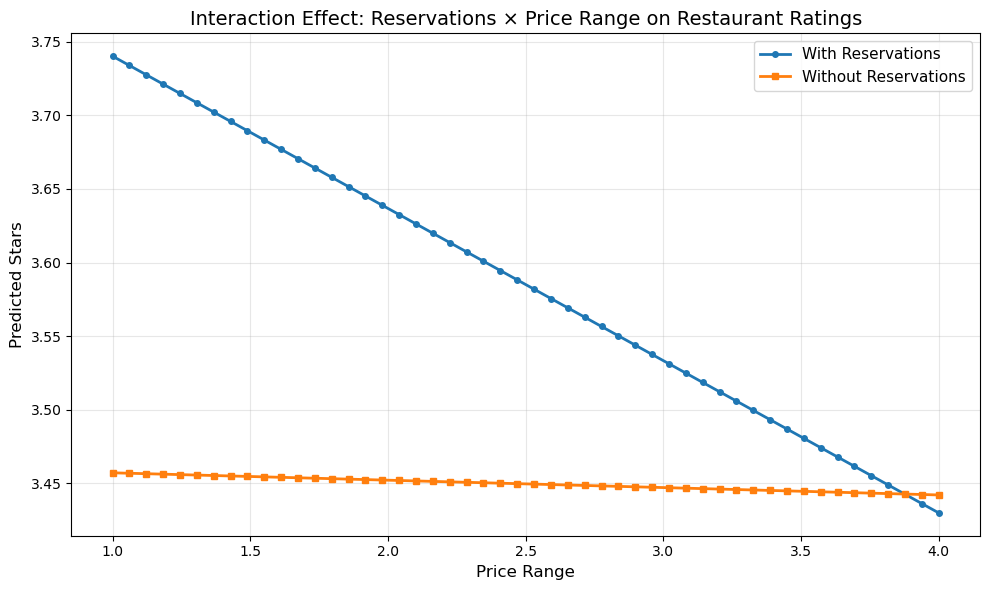

In [ ]:
# Visualization of the interaction effect
import matplotlib.pyplot as plt

# Create predicted values for visualization
# Vary RestaurantsPriceRange2 and RestaurantsReservations
price_range = np.linspace(df['RestaurantsPriceRange2'].min(), df['RestaurantsPriceRange2'].max(), 50)

# For restaurants with reservations = 1
reservations_1 = np.ones_like(price_range)
interaction_1 = reservations_1 * price_range

# For restaurants with reservations = 0
reservations_0 = np.zeros_like(price_range)
interaction_0 = reservations_0 * price_range

# Use mean values for other predictors
mean_delivery = df['RestaurantsDelivery'].mean()
mean_review_count = df['review_count'].mean()
mean_outdoor = df['OutdoorSeating'].mean()
mean_kids = df['GoodForKids'].mean()
mean_credit = df['BusinessAcceptsCreditCards'].mean()
mean_takeout = df['RestaurantsTakeOut'].mean()

# Predictions for both scenarios
fig, ax = plt.subplots(figsize=(10, 6))

# With reservations
pred_data_with_res = pd.DataFrame({
    'const': 1,
    'RestaurantsDelivery': [mean_delivery]*len(price_range),
    'review_count': [mean_review_count]*len(price_range),
    'RestaurantsPriceRange2': price_range,
    'RestaurantsReservations': reservations_1,
    'Reservations_x_PriceRange': interaction_1,
    'OutdoorSeating': [mean_outdoor]*len(price_range),
    'GoodForKids': [mean_kids]*len(price_range),
    'BusinessAcceptsCreditCards': [mean_credit]*len(price_range),
    'RestaurantsTakeOut': [mean_takeout]*len(price_range)
})
pred_with_res = interaction_model.predict(pred_data_with_res)

# Without reservations
pred_data_without_res = pd.DataFrame({
    'const': 1,
    'RestaurantsDelivery': [mean_delivery]*len(price_range),
    'review_count': [mean_review_count]*len(price_range),
    'RestaurantsPriceRange2': price_range,
    'RestaurantsReservations': reservations_0,
    'Reservations_x_PriceRange': interaction_0,
    'OutdoorSeating': [mean_outdoor]*len(price_range),
    'GoodForKids': [mean_kids]*len(price_range),
    'BusinessAcceptsCreditCards': [mean_credit]*len(price_range),
    'RestaurantsTakeOut': [mean_takeout]*len(price_range)
})
pred_without_res = interaction_model.predict(pred_data_without_res)

ax.plot(price_range, pred_with_res, 'o-', linewidth=2, label='With Reservations', markersize=4)
ax.plot(price_range, pred_without_res, 's-', linewidth=2, label='Without Reservations', markersize=4)
ax.set_xlabel('Price Range', fontsize=12)
ax.set_ylabel('Predicted Stars', fontsize=12)
ax.set_title('Interaction Effect: Reservations × Price Range on Restaurant Ratings', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Display regression results as a formatted table
import pandas as pd

# Extract regression results
results_df = pd.DataFrame({
    'Coefficient': interaction_model.params,
    'Std Error': interaction_model.bse,
    't-statistic': interaction_model.tvalues,
    'P-value': interaction_model.pvalues
})

print("\n=== Interaction Model Results ===")
print(f"R-squared: {interaction_model.rsquared:.4f}")
print(f"Adjusted R-squared: {interaction_model.rsquared_adj:.4f}")
print(f"F-statistic: {interaction_model.fvalue:.4f}")
print(f"Prob (F-statistic): {interaction_model.f_pvalue:.4e}\n")
print(results_df.round(6))


=== Interaction Model Results ===
R-squared: 0.1319
Adjusted R-squared: 0.1317
F-statistic: 529.4994
Prob (F-statistic): 0.0000e+00

                            Coefficient  Std Error  t-statistic   P-value
const                          3.659851   0.017289   211.684365  0.000000
RestaurantsDelivery           -0.388589   0.010053   -38.654123  0.000000
review_count                   0.000592   0.000021    28.377410  0.000000
RestaurantsPriceRange2        -0.005014   0.007969    -0.629212  0.529215
RestaurantsReservations        0.381345   0.025558    14.920672  0.000000
Reservations_x_PriceRange     -0.098381   0.014078    -6.988387  0.000000
OutdoorSeating                 0.190160   0.009582    19.844648  0.000000
GoodForKids                   -0.245318   0.010476   -23.418042  0.000000
BusinessAcceptsCreditCards    -0.130573   0.013872    -9.412430  0.000000
RestaurantsTakeOut             0.250140   0.015807    15.824698  0.000000


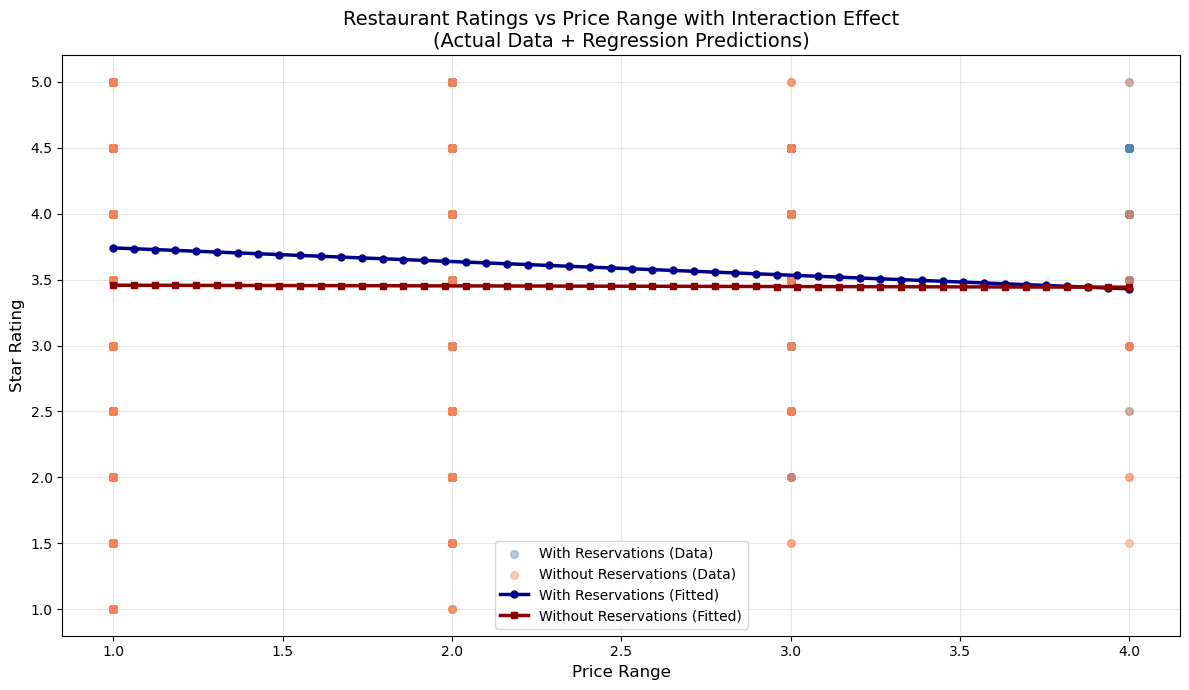

In [ ]:
# Scatterplot with actual data and trendlines
fig, ax = plt.subplots(figsize=(12, 7))

# Separate data by reservation status
with_res = df[df['RestaurantsReservations'] == 1]
without_res = df[df['RestaurantsReservations'] == 0]

# Plot actual data points
ax.scatter(with_res['RestaurantsPriceRange2'], with_res['stars'],
           alpha=0.4, s=30, label='With Reservations (Data)', color='steelblue')
ax.scatter(without_res['RestaurantsPriceRange2'], without_res['stars'],
           alpha=0.4, s=30, label='Without Reservations (Data)', color='coral')

# Add trendlines from regression
ax.plot(price_range, pred_with_res, 'o-', linewidth=2.5,
        label='With Reservations (Fitted)', color='darkblue', markersize=5)
ax.plot(price_range, pred_without_res, 's-', linewidth=2.5,
        label='Without Reservations (Fitted)', color='darkred', markersize=5)

ax.set_xlabel('Price Range', fontsize=12)
ax.set_ylabel('Star Rating', fontsize=12)
ax.set_title('Restaurant Ratings vs Price Range with Interaction Effect\n(Actual Data + Regression Predictions)', fontsize=14)
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

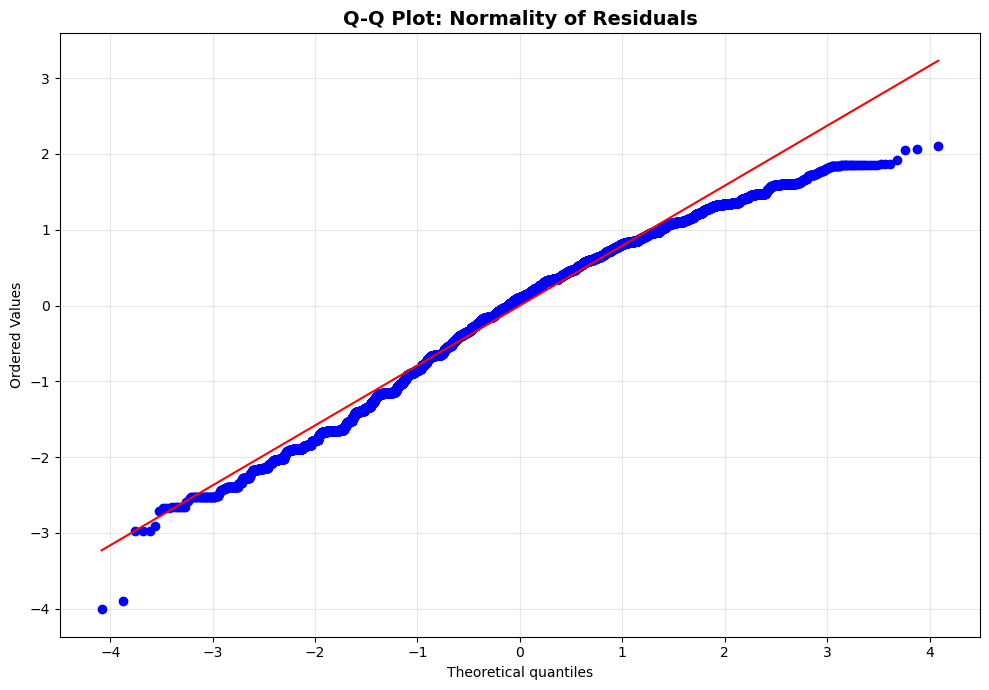

In [ ]:
# Q-Q Plot for normality assessment
from scipy import stats

# Get residuals
residuals = interaction_model.resid

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(10, 7))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Normality of Residuals', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()